# Uvod u podatke



Tematika mog ispitnog projekta jeste vizualizacija i analiza podataka iz mog custom F1 dataseta.  

Prva stvar koju radim jeste učitavanje podataka iz Databricks File Systema u moju (kratkotrajnu) Spark sesiju. Nakon učitavanja, naravno, provjeravam šta sam tačno učitao.  

Ono što je očigledno jeste da svi blokovi koda prvo prebacuju podatke iz Spark DataFrame-a u Pandas ekvivalent. Ovo je urađeno iz razloga što mi Spark operacije ne bi bile korisne, budući da se sve ionako izvršava s jedne mašine u sklopu Databricks Community Edition platforme.  


In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Telemetry Analysis").getOrCreate()

data_path = "dbfs:/FileStore/combined_telemetry_meeting_9590-1.csv"
telemetry_df = spark.read.csv(data_path, header=True, inferSchema=True)

telemetry_df.show()
telemetry_df.printSchema()
telemetry_df.select("driver_number").distinct().show()
telemetry_df.select("tyre_compound").distinct().show()


+--------------------+-------------+------------------+------------------+------+--------+---+-----+-------------------+------------------+------------------+------------------+---------------+--------+--------+--------+-----------------+--------------+----------+----------+-------------+
|                date|driver_number|               rpm|             speed|n_gear|throttle|drs|brake|                  x|                 y|     gap_to_leader|          interval|air_temperature|humidity|pressure|rainfall|track_temperature|wind_direction|wind_speed|lap_number|tyre_compound|
+--------------------+-------------+------------------+------------------+------+--------+---+-----+-------------------+------------------+------------------+------------------+---------------+--------+--------+--------+-----------------+--------------+----------+----------+-------------+
|2024-09-01 13:05:...|         81.0|           11045.0|             313.0|   8.0|    99.0|1.0|  0.0| -1359.011540676923|      -497

Prije bilo kakvog detaljnog rada ili analize, bitno je da znam s čim radim. Podaci iz Formule 1 vezani za jedan bolid (auto) nazivaju se dalje kao "telemetry". Ti podaci predstavljaju stanje bolida, vozačeve akcije, poziciju, krug i aktuelne atmosferske pojave u svakom izmjerenom (ili u nekim slučajevima ručno interpoliranom) trenutku vremena.  


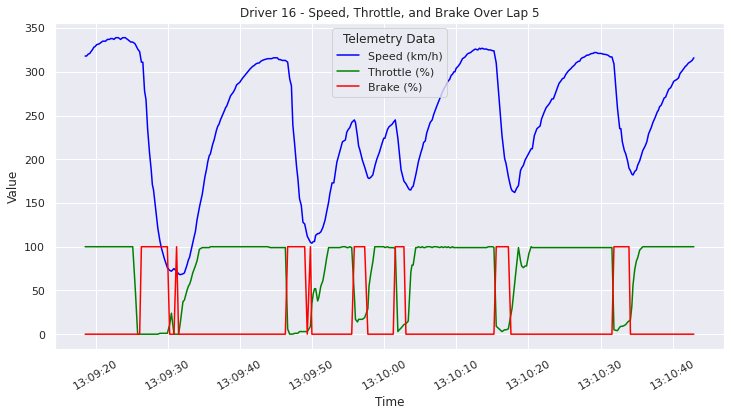

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = telemetry_df.toPandas()

pandas_df["date"] = pd.to_datetime(pandas_df["date"])

target_lap = 5  # mozemo od 2 do 53 kruga
target_driver = 16  # u opticaju su 16, 1, 44, 55, 81

if "lap_number" in pandas_df.columns and "driver_number" in pandas_df.columns:
    pandas_df = pandas_df[(pandas_df["lap_number"] == target_lap) & 
                          (pandas_df["driver_number"] == target_driver)]

required_columns = {"date", "speed", "throttle", "brake"}
missing_columns = required_columns - set(pandas_df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")


sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.lineplot(data=pandas_df, x="date", y="speed", label="Speed (km/h)", color="blue")
sns.lineplot(data=pandas_df, x="date", y="throttle", label="Throttle (%)", color="green")
sns.lineplot(data=pandas_df, x="date", y="brake", label="Brake (%)", color="red")

plt.title(f"Driver {target_driver} - Speed, Throttle, and Brake Over Lap {target_lap}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(title="Telemetry Data")
plt.xticks(rotation=30) 
plt.show()


Gornji grafik prikazan pomoću SeaBorn i MatPlotLib biblioteka predstavlja relevantnu telemetriju u toku jednog trkačkog kruga. U ovom slučaju, to je vozač broj 16 (Charles LeClerc) za vrijeme 5. kruga.  

## Bitna napomena:  
Gornji grafik jeste najbliža stvar pravoj telemetriji. Naime, brojni inženjeri i naučnici zaposleni u svim timovima F1 svoje analize rade na "potpuno" istim grafikonima (treba naravno razumjeti da oni imaju pristup nekim podacima koji nikada ne smiju biti objavljeni, poput **steering_angle**). Dodatne informacije se mogu pronaći na idućem linku: [YouTube Video](https://www.youtube.com/watch?v=lfqkhCCq5sg&t=181s&pp=ygUUY2hhaW4gYmVhciB0ZWxlbWV0cnk%3D)  


## Analize:  
Sada se bavim analizama koje se tiču događaja sa "Velike Nagrade Italije" trke koja je vožena 1. septembra 2024. godine na popularnoj (pogotovo nama iz naših krajeva) stazi Monza (Autodromo Nazionale Monza, koja je izgrađena 1922. godine).  

Sve analize se tiču bitne odluke Oskara Pijastrija (vozač broj 81) koji će u 39. krugu od 53 poći na promjenu guma. Ta promjena guma će, faktički, našem miljeniku Šarlu Lekleru (vozač broj 16) pokloniti poziciju na stazi i čist vazduh koji će on maksimalno iskoristiti na putu do pobjede.  

### Bitna napomena  
Sve ove analize sa svojim hipotezama će uvijek biti korisne ciljnim grupama koje se interesuju za F1. To će biti, prije svega, inženjeri, naučnici i na kraju i sami fanovi sporta. Pomoću analiza će biti moguće vidjeti drugu sliku sporta.  


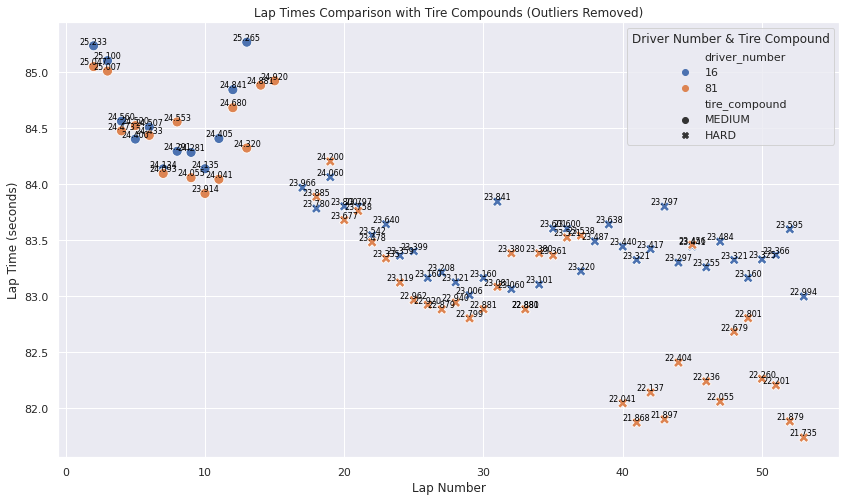

In [0]:
pandas_df = telemetry_df.toPandas()

pandas_df["date"] = pd.to_datetime(pandas_df["date"])

target_drivers = [16, 81]  

def process_driver_data(driver_number, df):
    driver_df = df[df["driver_number"] == driver_number]

    lap_times = (
        driver_df.groupby("lap_number")
        .agg(min_time=("date", "min"), max_time=("date", "max"), tire_compound=("tyre_compound", "first"))
        .reset_index()
    )

    lap_times["lap_time"] = (lap_times["max_time"] - lap_times["min_time"]).dt.total_seconds()

    def format_lap_time(seconds):
        minutes = int(seconds // 60)
        seconds_remaining = seconds % 60
        seconds_str = f"{seconds_remaining:0.3f}"  
        return f"{seconds_str}"

    lap_times["formatted_lap_time"] = lap_times["lap_time"].apply(format_lap_time)

    # Ne zelimo krugove kada vozac ulati u pit box i izlazi iz njega jer je on tada uzasno spor
    Q1 = lap_times["lap_time"].quantile(0.25)
    Q3 = lap_times["lap_time"].quantile(0.75)
    IQR = Q3 - Q1

    # izbacujemo te nepozeljne krugove
    filtered_lap_times = lap_times[
        (lap_times["lap_time"] >= (Q1 - 1.5 * IQR)) & (lap_times["lap_time"] <= (Q3 + 1.5 * IQR))
    ]

    return filtered_lap_times

driver_data = {}
for driver in target_drivers:
    driver_data[driver] = process_driver_data(driver, pandas_df)

combined_data = pd.concat(
    [driver_data[driver].assign(driver_number=driver) for driver in target_drivers]
)

sns.set_theme(style="darkgrid")
plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=combined_data,
    x="lap_number",
    y="lap_time",
    hue="driver_number",
    style="tire_compound",
    palette="deep",
    s=100,
)

for i, row in combined_data.iterrows():
    plt.text(
        row["lap_number"],  
        row["lap_time"],    
        row["formatted_lap_time"],  
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=8,
        color="black",
    )
plt.title("Lap Times Comparison with Tire Compounds (Outliers Removed)")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.legend(title="Driver Number & Tire Compound")
plt.grid(True)
plt.show()


Na gornjem grafiku predstavljamo zapravo vremena svih krugova koje će vozači 81 i 16 odraditi od početka do samog kraja trke. Podatak samog trajanja jednog kruga je dobijen računajući vremensku razliku između prvog izmerenog vremena jednog kruga jednog vozača i poslednjeg (svaki red jeste jedan izmereni trenutak). Zatim gledamo koje su gume korišćene u kom trenutku. U F1, izbor guma je najbitnija odluka koju tim i vozač moraju da donesu i često se donosi koristeći ogromne resurse (ML modeli i analize ljudi sa raznim doktoratima iz relevantnih oblasti).  


Sada, znajući da će vozači biti na gumama različitih starosti, pametno bi bilo da pogledamo telemetriju da vidimo da li postoji nešto zanimljivo u njihovim stilovima vožnje.  


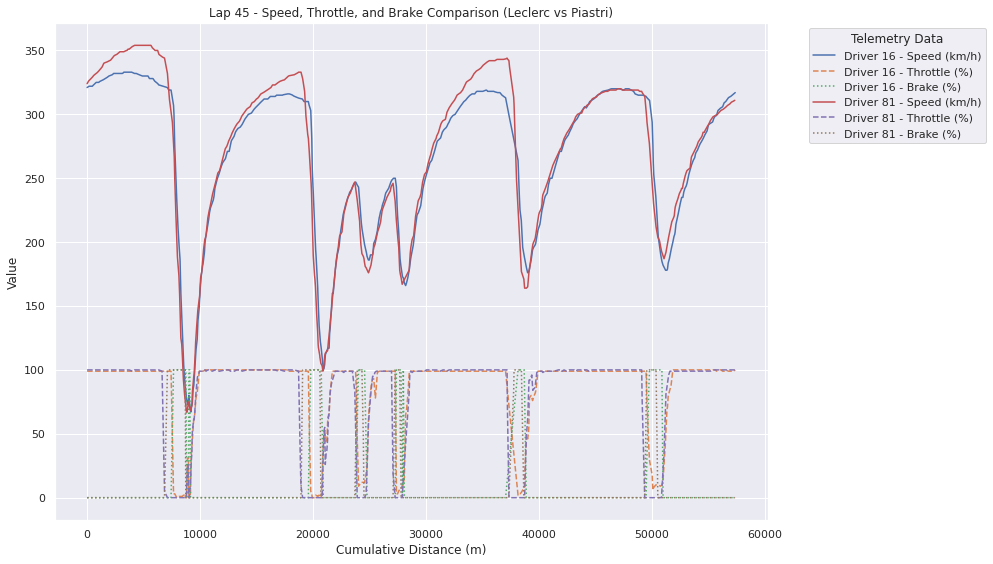

In [0]:
import numpy as np
pandas_df = telemetry_df.toPandas()
pandas_df["date"] = pd.to_datetime(pandas_df["date"])
target_lap = 45  
target_drivers = [16, 81] 

if "lap_number" in pandas_df.columns and "driver_number" in pandas_df.columns:
    filtered_df = pandas_df[(pandas_df["lap_number"] == target_lap) & 
                            (pandas_df["driver_number"].isin(target_drivers))]

required_columns = {"x", "y", "speed", "throttle", "brake", "driver_number"}
missing_columns = required_columns - set(filtered_df.columns)
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

# da bih normalizovao u odnosu na kolicinu staze koju su presli (bez ovoga se desava da grafik jednog bude 4 sekunde nakon drugog sto zapravo ima smisla)
def calculate_distance(df):
    df["distance"] = np.sqrt(df["x"].diff()**2 + df["y"].diff()**2)
    df["distance"].iloc[0] = 0
    df["cumulative_distance"] = df["distance"].cumsum()
    return df


filtered_df = filtered_df.groupby("driver_number").apply(calculate_distance).reset_index(drop=True)

sns.set_theme(style="darkgrid")
plt.figure(figsize=(14, 8))

for driver in target_drivers:
    driver_data = filtered_df[filtered_df["driver_number"] == driver]
    sns.lineplot(data=driver_data, x="cumulative_distance", y="speed", label=f"Driver {driver} - Speed (km/h)", linestyle="-")
    sns.lineplot(data=driver_data, x="cumulative_distance", y="throttle", label=f"Driver {driver} - Throttle (%)", linestyle="--")
    sns.lineplot(data=driver_data, x="cumulative_distance", y="brake", label=f"Driver {driver} - Brake (%)", linestyle=":")

plt.title(f"Lap {target_lap} - Speed, Throttle, and Brake Comparison (Leclerc vs Piastri)")
plt.xlabel("Cumulative Distance (m)")
plt.ylabel("Value")
plt.legend(title="Telemetry Data", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Pravimo grafik telemetrije za 45. krug kada će efektivno gume vozača 81 biti „zagrijane“ i u svom prozoru najboljih performansi. Ono što je odmah očigledno jeste razlika u maksimalnoj brzini, dok je ono manje očigledno (dok ne stavimo naočale) zapravo sitna razlika u trenutku pritiskanja gasa i kočnice.  

Anegdotalno znamo da onaj ko više koči obično bude sporiji. Ove razlike u telemetriji predstavljaju različit način vožnje.  

- Vozač 81 vozi na vrhuncu svojih mogućnosti, svjestan da ima novije gume i da mu preostaje još 8 krugova da prestigne vozača 16 za pobjedu.  

- Vozač 16 takođe vozi na vrhuncu svojih mogućnosti, ali njegov problem su istrošene gume koje polako gube performanse. U ovakvim situacijama, povjerenje vozača u svoje gume pravi ključnu razliku. Ako vozač osjeti da mu gume popuštaju, mora postepeno smanjiti tempo tako što će u krivine ulaziti s manjom brzinom i pažljivo birati svoju trkačku liniju kroz krivinu (jer se gume troše brže agresivnim ulascima i izlascima iz krivina).  


## Prva analiza: Upoređivanje distribucija brzina vozača pomoću Kolmogorov-Smirnov testa
### Ideja
Želimo da vidimo da li postoji statistički značaj između različitih brzina koje vozači dostižu tokom svojih krugova dok se međusobno jure. Cilj je da provjerimo da li je ono što smo vizuelno primijetili zapravo statistički značajno.

### Hipoteze
- Nulta hipoteza (H₀): Distribucije brzina vozača 16 i vozača 81 su značajno različite, što ukazuje da su njih dvojica na različitim strategijama, što je u skladu s našim saznanjima. (Jedan vozač želi da izdrži do kraja bez promjene guma, takozvano „kampovanje“ na stazi, dok drugi pokušava bržim krugovima da nadoknadi gubitak vremena usljed promjene na nove gume.)
- Alternativna hipoteza (H₁): Distribucije brzina vozača 16 i vozača 81 su iste, što sugeriše da je cijela priča o korišćenju guma različite starosti i strategijama potpuno nebitna. 








In [0]:
from scipy.stats import ks_2samp

driver_16_speed = filtered_df[filtered_df["driver_number"] == 16]["speed"]
driver_81_speed = filtered_df[filtered_df["driver_number"] == 81]["speed"]

ks_stat, p_value = ks_2samp(driver_16_speed, driver_81_speed)

print(f"KS Statistic: {ks_stat}, P-value: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Ne odbijamo nultu hipotezu, postoji itekako znacajna razlika")
else:
    print("Odbijamo nultu hipotezu")

KS Statistic: 0.1196319018404908, P-value: 0.00017912514406603908
Ne odbijamo nultu hipotezu, postoji itekako znacajna razlika


### Zaključak:  
Nulta hipoteza je tačna, mada KS vrijednosti bi možda mogle da budu malo veće.  

### Rezultat  
KS Statistika: 0.1196, P-vrednost: 0.000179  


Sada, znajući da su njihove razlike validne, možemo da probamo da vizualizujemo njihove međusobne vremenske razlike u periodu vremena od 40. kruga do 53., odnosno do samog kraja trke. Taman možemo da uporedimo *gap_to_leader* polje naših redova sa vrednostima koje možemo ručno da izračunamo.  


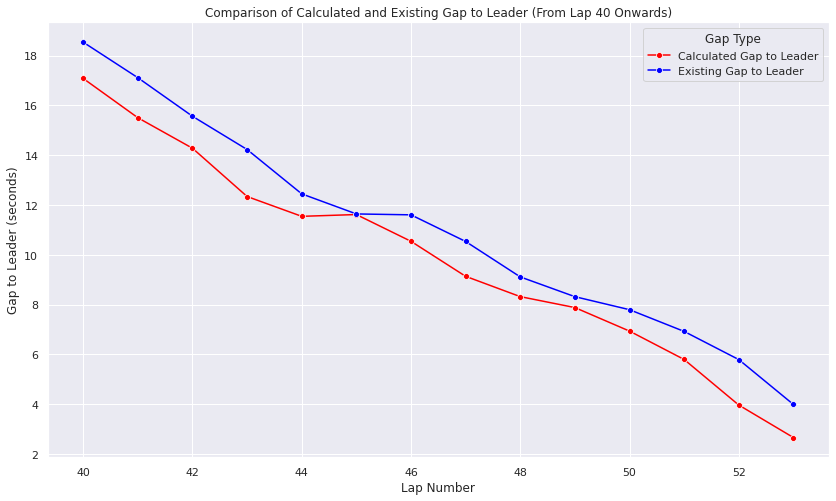

In [0]:
pandas_df = telemetry_df.toPandas()
pandas_df["date"] = pd.to_datetime(pandas_df["date"])

target_drivers = [16, 81]

def process_driver_data(driver_number, df):
    driver_df = df[df["driver_number"] == driver_number]

    lap_times = (
        driver_df.groupby("lap_number")
        .agg(min_time=("date", "min"), max_time=("date", "max"), tire_compound=("tyre_compound", "first"))
        .reset_index()
    )

    lap_times["lap_time"] = (lap_times["max_time"] - lap_times["min_time"]).dt.total_seconds()

    return lap_times

driver_data = {}
for driver in target_drivers:
    driver_data[driver] = process_driver_data(driver, pandas_df)

gap_data = pd.merge(
    driver_data[16][["lap_number", "max_time", "lap_time"]],
    driver_data[81][["lap_number", "max_time", "lap_time"]],
    on="lap_number",
    suffixes=("_16", "_81")
)
# podaci koje rucno racunamo
gap_data["calculated_gap_to_leader"] = (gap_data["max_time_81"] - gap_data["max_time_16"]).dt.total_seconds()
# podaci iz naseg polja
existing_gap_data = (
    pandas_df[pandas_df["driver_number"] == 81]
    .groupby("lap_number")
    .agg(existing_gap_to_leader=("gap_to_leader", "first"))
    .reset_index()
)

gap_data = pd.merge(
    gap_data,
    existing_gap_data,
    on="lap_number",
    how="left"
)

gap_data["gap_difference"] = gap_data["existing_gap_to_leader"] - gap_data["calculated_gap_to_leader"]

gap_data = gap_data[gap_data["lap_number"] >= 40]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=gap_data,
    x="lap_number",
    y="calculated_gap_to_leader",
    marker="o",
    color="red",
    label="Calculated Gap to Leader"
)

sns.lineplot(
    data=gap_data,
    x="lap_number",
    y="existing_gap_to_leader",
    marker="o",
    color="blue",
    label="Existing Gap to Leader"
)

plt.title("Comparison of Calculated and Existing Gap to Leader (From Lap 40 Onwards)")
plt.xlabel("Lap Number")
plt.ylabel("Gap to Leader (seconds)")
plt.legend(title="Gap Type")
plt.grid(True)
plt.show()

Kao rezultat vidimo očekivano, njihova razlika počinje na ~18 sekundi i na samom kraju se može procijeniti na nekih 2.5 sekundi. Primjetna je razlika između ručno izračunate i izvađene vrijednosti, ovdje treba biti pažljiv i informisati se službenim izvorima vremenskih podataka.

Na idućem linku: https://www.formula1.com/en/results/2024/races/1244/italy/race-result može se vidjeti da je po službenim izvorima vremenska razlika prilikom ulaska u cilj 2.664 sekunde. Za sve iduće korake uzimamo onu vrijednost koja je bliža službenoj, što je u našem slučaju naša ručno izračunata razlika.

## Druga Analiza: Da li je moguće da se preticanje desi prije 53. kruga, a ako nije, kada je onda moguće da se desi?
### Ideja:
Želimo da vidimo da li je moguće po modelu Polinomske regresije da se uopšte desi preticanje, događaj kada je razlika između dva vozača 0. Ta regresiona linija će predstavljati tu razliku. U slučaju da je na osnovu nje moguće preticanje, to nam onda govori da je vozač koji je jurio zapravo u jednom od tih krugova napravio grešku koja ga je koštala vremenom, jer bi onda u odnosu na generalni tempo koji regresivno računamo bilo moguće da dođe do preticanja. Takođe ćemo polinomsku regresiju iskoristiti da vidimo jedan "What If?" scenario, odnosno koliko bi trka trebalo da je duža da bismo mogli da dođemo do situacije preticanja.

### Hipoteze
- Nulta hipoteza (H₀): Da, preticanje prije 53. kruga je itekako moguće, što sugeriše da je Oskar Pijastri zapravo mogao da pobijedi na trci.
- Alternativna hipoteza (H₁): Nije moguće da dođe do preticanja, čak je i upitno da li će do prestizanja uopšte i doći. U ovom slučaju je bitno da znamo tačan krug prestizanja (vrijednost ili NaN).

Predicted overtake lap: 57.0
R²: 0.9852, MSE: 0.3012
F-statistics: [808.35329443 630.91048518], p-values: [4.32326000e-13 2.10729265e-12]
Odbijam nultu hipotezu, prestizanje se nece desiti prije 53. kruga vec 57.0.).


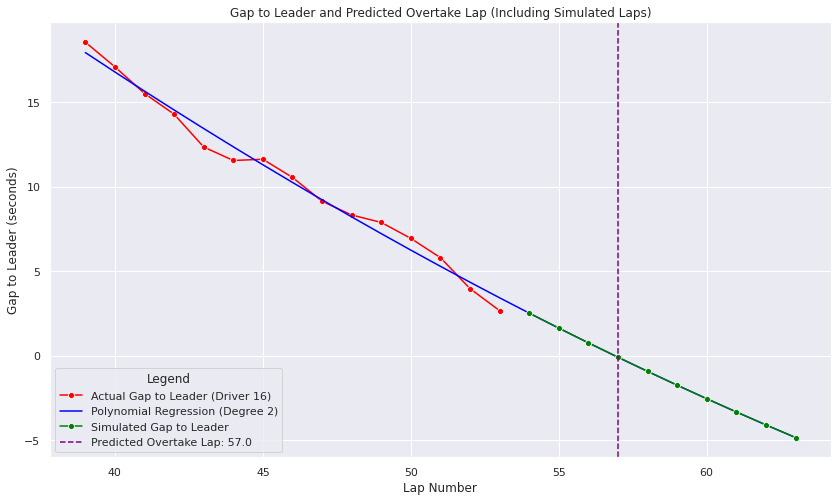

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression


pandas_df = telemetry_df.toPandas()

pandas_df["date"] = pd.to_datetime(pandas_df["date"])

target_drivers = [16, 81] 

def process_driver_data(driver_number, df):
    driver_df = df[df["driver_number"] == driver_number]

    lap_times = (
        driver_df.sort_values("date")  
        .groupby("lap_number")
        .tail(1) 
        [["lap_number", "date", "tyre_compound"]]
        .rename(columns={"date": "last_time"})
    )

    lap_times["lap_time"] = lap_times.groupby("lap_number")["last_time"].diff().dt.total_seconds()

    return lap_times

driver_data = {}
for driver in target_drivers:
    driver_data[driver] = process_driver_data(driver, pandas_df)

gap_data = pd.merge(
    driver_data[16][["lap_number", "last_time"]],
    driver_data[81][["lap_number", "last_time"]],
    on="lap_number",
    suffixes=("_16", "_81")
)

gap_data["gap_to_leader"] = (gap_data["last_time_81"] - gap_data["last_time_16"]).dt.total_seconds()

gap_data = gap_data[gap_data["lap_number"] >= 39]

X = gap_data["lap_number"].values.reshape(-1, 1)  
y = gap_data["gap_to_leader"].values  

degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

y_pred = model.predict(X_poly)

overtake_lap = None
for lap, pred_gap in zip(X.flatten(), y_pred):
    if pred_gap <= 0:
        overtake_lap = lap
        break

if overtake_lap is None:
    additional_laps = 10  
    max_lap = gap_data["lap_number"].max()
    simulated_laps = np.arange(max_lap + 1, max_lap + additional_laps + 1).reshape(-1, 1)

    X_simulated_poly = poly_features.transform(simulated_laps)
    y_simulated_pred = model.predict(X_simulated_poly)

    for lap, pred_gap in zip(simulated_laps.flatten(), y_simulated_pred):
        if pred_gap <= 0:
            overtake_lap = lap
            break

print(f"Predicted overtake lap: {overtake_lap}")

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f"R²: {r2:.4f}, MSE: {mse:.4f}")

f_statistics, p_values = f_regression(X_poly[:, 1:], y)  
print(f"F-statistics: {f_statistics}, p-values: {p_values}")


alpha = 0.05  

if overtake_lap is not None:
    if overtake_lap > 53:
        print(f"Odbijam nultu hipotezu, prestizanje se nece desiti prije 53. kruga vec {overtake_lap}.")
    else:
        print("Prestizanje je moguce da se desi prije 53 kruga.")
else:
    print("Uopste nece biti prestizanja!")

extended_gap_data = pd.concat(
    [
        gap_data[["lap_number", "gap_to_leader"]],
        pd.DataFrame({"lap_number": simulated_laps.flatten(), "gap_to_leader": y_simulated_pred})
    ],
    ignore_index=True
)

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=gap_data,
    x="lap_number",
    y="gap_to_leader",
    marker="o",
    color="red",
    label="Actual Gap to Leader (Driver 16)"
)

sns.lineplot(
    x=extended_gap_data["lap_number"],
    y=model.predict(poly_features.transform(extended_gap_data["lap_number"].values.reshape(-1, 1))),
    color="blue",
    label=f"Polynomial Regression (Degree {degree})"
)

if overtake_lap is not None:
    simulated_data = pd.DataFrame({
        "lap_number": simulated_laps.flatten(),
        "gap_to_leader": y_simulated_pred
    })
    sns.lineplot(
        data=simulated_data,
        x="lap_number",
        y="gap_to_leader",
        marker="o",
        color="green",
        label="Simulated Gap to Leader"
    )

if overtake_lap:
    plt.axvline(x=overtake_lap, color="purple", linestyle="--", label=f"Predicted Overtake Lap: {overtake_lap}")

plt.title("Gap to Leader and Predicted Overtake Lap (Including Simulated Laps)")
plt.xlabel("Lap Number")
plt.ylabel("Gap to Leader (seconds)")
plt.legend(title="Legend")
plt.grid(True)
plt.show()

### Zaključak:
Na osnovu polinomske regresije, test pokazuje da je **prestizanje nemoguće prije završetka trke**. Dobijeni rezultati ukazuju da bi se prestizanje eventualno dogodilo tek u 57. krugu, što znači da je potrebno 4 dodatna kruga da bi do toga došlo. Ovo je u skladu sa statističkim testovima, gdje su P-vrijednosti izuzetno niske , što potvrđuje pouzdanost modela.

Međutim, ovaj rezultat otvara vrata za dalju analizu, na primjer: **"Šta bi se desilo da je vozač 81 (Oskar Pijastri) 4 kruga ranije promijenio gume?"** Ovaj scenario bi mogao biti predmet budućih istraživanja, ali zbog kompleksnosti i vremenskih ograničenja, sada prelazimo na druge analize sa drugih datasetova.

### Rezultati:
- Predviđeni krug prestizanja: 57.0
- R²: 0.9852 (model objašnjava 98.52% varijance u podacima)
- MSE: 0.3012 (prosječna kvadratna greška je relativno niska)
- F-statistika: [808.35, 630.91] (visoke vrijednosti ukazuju na značajnost modela)
- P-vrijednosti: [4.32e-13, 2.11e-12] (izuzetno niske, što potvrđuje statističku značajnost)